<a href="https://colab.research.google.com/github/Ujjwalb2/YOLO-Parking/blob/main/Copy_of_Parking_Space_YOLO_NAS_Train_%26_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install ultralytics

In [14]:

!pip -q install ultralytics==8.3.38 scikit-learn pandas numpy pillow onnx onnxruntime jedi ipython


In [7]:
from ultralytics import YOLO
import torch, os, glob, random
from pathlib import Path
import pandas as pd, numpy as np
from PIL import Image
from sklearn.cluster import DBSCAN

In [8]:
import kagglehub
path = kagglehub.dataset_download("ammarnassanalhajali/pklot-dataset")
print("Dataset path:", path)

# Collect all image paths
def list_images(root):
    exts = (".jpg",".jpeg",".png")
    return [str(p) for p in Path(root).rglob("*") if p.suffix.lower() in exts]

Dataset path: /root/.cache/kagglehub/datasets/ammarnassanalhajali/pklot-dataset/versions/1


In [9]:
image_paths = list_images(path)
print("Found images:", len(image_paths))
assert len(image_paths) > 0, "No images found. Check dataset path above."

# --------- 3) DETECTION USING COCO PRETRAINED YOLOv8n ----------



Found images: 12416


In [10]:
model = YOLO("yolov8n.pt")  # small, fast, pretrained on COCO

100%|██████████| 6.25M/6.25M [00:00<00:00, 20.5MB/s]


In [11]:
VEH_IDS = {2, 3, 5, 7}  # car, motorcycle, bus, truck

pred_dir = Path("artifacts/predictions")
pred_dir.mkdir(parents=True, exist_ok=True)
rows = []

In [12]:
# -------- SAFE BATCHED INFERENCE --------
from tqdm import tqdm
import gc

rows = []
batch_size = 25  # You can raise to 50 if GPU memory allows

# Split image_paths into smaller batches
batches = [image_paths[i:i+batch_size] for i in range(0, len(image_paths), batch_size)]

for batch_idx, batch in enumerate(tqdm(batches, desc="Running YOLOv8 in batches")):
    try:
        results = model.predict(
            source=batch,
            imgsz=640,
            conf=0.4,
            iou=0.7,
            stream=False,    # we already loop batches manually
            verbose=False,
            device=0 if torch.cuda.is_available() else 'cpu'
        )

        for r in results:
            w, h = Image.open(r.path).size
            if not r.boxes or len(r.boxes) == 0:
                continue
            for (x1, y1, x2, y2), c, k in zip(
                    r.boxes.xyxy.cpu().numpy(),
                    r.boxes.conf.cpu().numpy(),
                    r.boxes.cls.cpu().numpy().astype(int)):
                if int(k) in VEH_IDS:
                    rows.append({
                        "image": Path(r.path).name,
                        "x1": float(x1), "y1": float(y1),
                        "x2": float(x2), "y2": float(y2),
                        "conf": float(c),
                        "cls_id": int(k),
                        "cls_name": model.model.names[int(k)],
                        "width": float(w), "height": float(h),
                        "cx": float((x1+x2)/2.0), "cy": float((y1+y2)/2.0)
                    })
    except RuntimeError as e:
        print(f"⚠️ Batch {batch_idx} skipped due to OOM: {e}")
        torch.cuda.empty_cache()
        gc.collect()
        continue

print(f"✅ Done — collected {len(rows)} vehicle detections.")


Running YOLOv8 in batches: 100%|██████████| 497/497 [02:45<00:00,  3.01it/s]

✅ Done — collected 109071 vehicle detections.


In [15]:
pred_csv = pred_dir / "predictions_flat.csv"
pd.DataFrame(rows).to_csv(pred_csv, index=False)
print(f"💾 Saved detections → {pred_csv}  ({len(rows)} vehicle boxes)")

# --------- 4) SPOT PREFERENCE ANALYTICS ----------
print("\nAnalyzing parking-spot occupancy...")

💾 Saved detections → artifacts/predictions/predictions_flat.csv  (109071 vehicle boxes)

Analyzing parking-spot occupancy...


In [16]:
df = pd.read_csv(pred_csv)
if df.empty:
    raise RuntimeError("No detections found — check confidence threshold or dataset sample.")

# Normalize centers to [0,1]
df["nx"], df["ny"] = df["cx"] / df["width"], df["cy"] / df["height"]

In [17]:
eps_norm = 0.02   # 2 % of image dimension
min_samp = 2
labels = DBSCAN(eps=eps_norm, min_samples=min_samp).fit_predict(df[["nx","ny"]])
df["spot_id"] = labels
df = df[df["spot_id"] != -1].copy()

In [18]:
pref = (df.groupby("spot_id")
          .agg(total_hits=("image","count"),
               unique_images=("image", lambda s: len(pd.unique(s))),
               mean_confidence=("conf","mean"))
          .reset_index()
          .sort_values(["total_hits","unique_images"], ascending=[False,False]))

# Compute normalized occupancy rate
pref["occupancy_rate"] = (pref["total_hits"] / pref["total_hits"].max()).round(4)

In [19]:
out_dir = Path("artifacts/analytics"); out_dir.mkdir(parents=True, exist_ok=True)
pref_path = out_dir / "spot_preference_vehicle_only.csv"
df.to_csv(out_dir / "vehicle_predictions_with_spot_id.csv", index=False)
pref.to_csv(pref_path, index=False)


In [20]:
import cv2
import matplotlib.pyplot as plt

sample_img = random.choice(image_paths)
im = cv2.imread(sample_img)[..., ::-1]
H, W, _ = im.shape
rows_img = df[df["image"] == Path(sample_img).name]

In [25]:
sample_img = random.choice(image_paths)  # or set a specific path

# Load as writable, contiguous BGR array
im_bgr = cv2.imread(str(sample_img))
if im_bgr is None:
    # fallback via PIL → BGR
    from PIL import Image
    im_bgr = cv2.cvtColor(np.array(Image.open(sample_img).convert("RGB")), cv2.COLOR_RGB2BGR)

im_bgr = np.ascontiguousarray(im_bgr)  # ensure C-contiguous & writable (no view)


In [26]:
rows_img = (
    df[df["image"] == Path(sample_img).name]
    .dropna(subset=["x1","y1","x2","y2"])
    .copy()
)

In [27]:
for _, r in rows_img.iterrows():
    x1, y1, x2, y2 = int(round(r.x1)), int(round(r.y1)), int(round(r.x2)), int(round(r.y2))
    color = (0, 255, 0)
    cv2.rectangle(im_bgr, (x1, y1), (x2, y2), color, 2)
    label = f"#{int(r.spot_id)}" if "spot_id" in r and pd.notna(r.spot_id) else r.get("cls_name","")
    cv2.putText(im_bgr, label, (x1, max(0, y1 - 5)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)


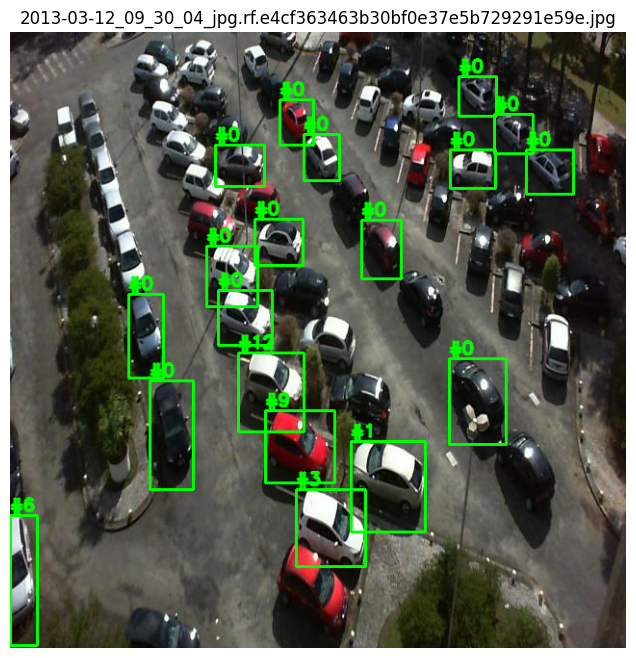

In [28]:
im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,8))
plt.imshow(im_rgb); plt.axis("off"); plt.title(Path(sample_img).name)
plt.show()

In [29]:
import pandas as pd, textwrap as tw, os
base = "artifacts/analytics"

files = {
    "predictions_flat.csv": "artifacts/predictions/predictions_flat.csv",
    "vehicle_predictions_with_spot_id.csv": f"{base}/vehicle_predictions_with_spot_id.csv",
    "spot_preference_vehicle_only.csv":    f"{base}/spot_preference_vehicle_only.csv",
}
for k,v in files.items():
    print(f"\n== {k} ==")
    df = pd.read_csv(v).head(3)
    display(df)

print("\n\nDATA DICTIONARY")
desc = {
    "predictions_flat.csv": {
        "image": "filename predicted on",
        "x1,y1,x2,y2": "bbox corners (pixels, image coordinate system)",
        "conf": "model confidence (0..1)",
        "cls_id": "COCO class id",
        "cls_name": "COCO class name (e.g., car, bus, truck, motorcycle)",
        "width,height": "image dimensions (pixels)",
        "cx,cy": "bbox center (pixels)"
    },
    "vehicle_predictions_with_spot_id.csv": {
        **{
          "image":"filename",
          "x1,y1,x2,y2,conf,cls_id,cls_name,width,height,cx,cy":"same as above"
        },
        "nx,ny":"normalized center (cx/width, cy/height) in [0,1]",
        "spot_id":"cluster index from DBSCAN (one physical spot ≈ one spot_id); -1 is noise (filtered out)"
    },
    "spot_preference_vehicle_only.csv": {
        "spot_id":"cluster index (one row per inferred spot)",
        "total_hits":"how many vehicle detections landed in this spot across all images",
        "unique_images":"in how many unique frames this spot had a vehicle",
        "mean_confidence":"mean model confidence over detections in this spot",
        "occupancy_rate":"normalized popularity of spot (total_hits / max(total_hits))"
    }
}
for name, cols in desc.items():
    print(f"\n{name}")
    for c, d in cols.items():
        print(f"  - {c}: {d}")



== predictions_flat.csv ==


image          x1          y1  \
0  2013-04-15_08_50_03_jpg.rf.fba29ba5ed7fe50daf2...  466.828979  350.892883   
1  2013-04-15_08_50_03_jpg.rf.fba29ba5ed7fe50daf2...  569.396423  152.729431   
2  2013-04-15_08_50_03_jpg.rf.fba29ba5ed7fe50daf2...  396.560303  234.448273   

           x2          y2      conf  cls_id cls_name  width  height  \
0  527.387024  433.752258  0.798985       2      car  640.0   640.0   
1  619.826599  205.000305  0.708149       2      car  640.0   640.0   
2  446.726807  300.668549  0.673702       2      car  640.0   640.0   

           cx          cy  
0  497.108002  392.322571  
1  594.611511  178.864868  
2  421.643555  267.558411


== vehicle_predictions_with_spot_id.csv ==


image          x1          y1  \
0  2013-04-15_08_50_03_jpg.rf.fba29ba5ed7fe50daf2...  466.828979  350.892883   
1  2013-04-15_08_50_03_jpg.rf.fba29ba5ed7fe50daf2...  569.396423  152.729431   
2  2013-04-15_08_50_03_jpg.rf.fba29ba5ed7fe50daf2...  396.560303  234.448273   

           x2          y2      conf  cls_id cls_name  width  height  \
0  527.387024  433.752258  0.798985       2      car  640.0   640.0   
1  619.826599  205.000305  0.708149       2      car  640.0   640.0   
2  446.726807  300.668549  0.673702       2      car  640.0   640.0   

           cx          cy        nx        ny  spot_id  
0  497.108002  392.322571  0.776731  0.613004        0  
1  594.611511  178.864868  0.929080  0.279476        0  
2  421.643555  267.558411  0.658818  0.418060        0


== spot_preference_vehicle_only.csv ==


spot_id  total_hits  unique_images  mean_confidence  occupancy_rate
0        0       83464           5494         0.596018          1.0000
1        3        4595           3607         0.601544          0.0551
2        4        3953           3504         0.639927          0.0474



DATA DICTIONARY

predictions_flat.csv
  - image: filename predicted on
  - x1,y1,x2,y2: bbox corners (pixels, image coordinate system)
  - conf: model confidence (0..1)
  - cls_id: COCO class id
  - cls_name: COCO class name (e.g., car, bus, truck, motorcycle)
  - width,height: image dimensions (pixels)
  - cx,cy: bbox center (pixels)

vehicle_predictions_with_spot_id.csv
  - image: filename
  - x1,y1,x2,y2,conf,cls_id,cls_name,width,height,cx,cy: same as above
  - nx,ny: normalized center (cx/width, cy/height) in [0,1]
  - spot_id: cluster index from DBSCAN (one physical spot ≈ one spot_id); -1 is noise (filtered out)

spot_preference_vehicle_only.csv
  - spot_id: cluster index (one row per inferred spot)
  - total_hits: how many vehicle detections landed in this spot across all images
  - unique_images: in how many unique frames this spot had a vehicle
  - mean_confidence: mean model confidence over detections in this spot
  - occupancy_rate: normalized popularity of spot (total_hi

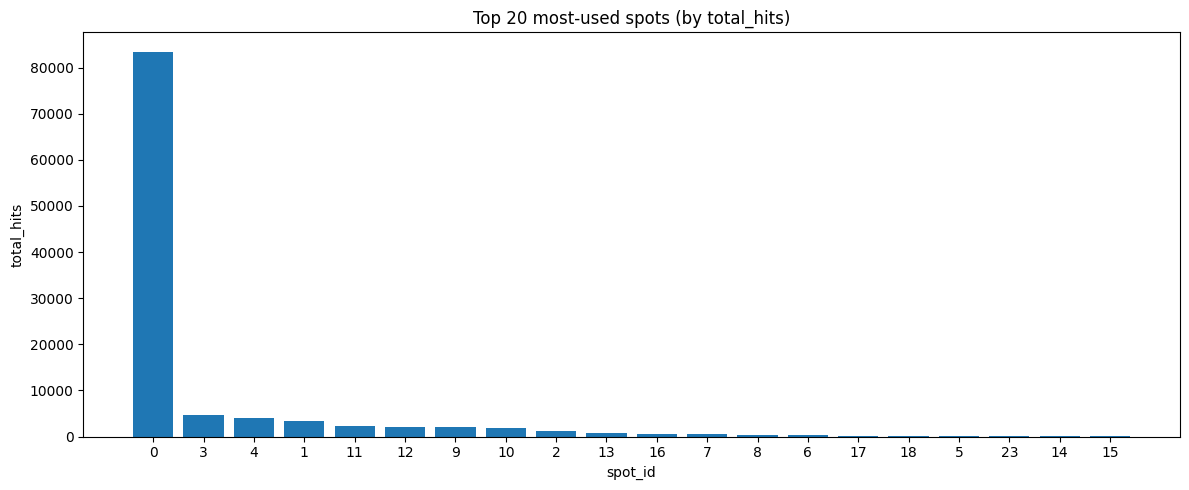

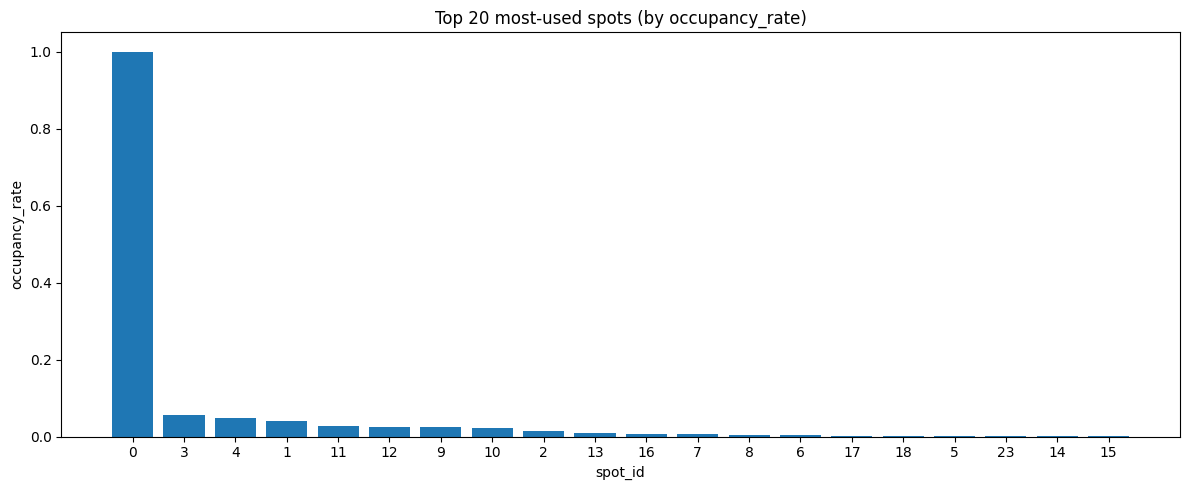

In [30]:
import pandas as pd, matplotlib.pyplot as plt, os
pref = pd.read_csv("artifacts/analytics/spot_preference_vehicle_only.csv")

topN = 20
head = pref.head(topN)
plt.figure(figsize=(12,5))
plt.bar([str(i) for i in head["spot_id"]], head["total_hits"])
plt.title(f"Top {topN} most-used spots (by total_hits)")
plt.xlabel("spot_id"); plt.ylabel("total_hits")
plt.tight_layout()
os.makedirs("artifacts/figures", exist_ok=True)
plt.savefig("artifacts/figures/top_spots_total_hits.png", dpi=160)
plt.show()

plt.figure(figsize=(12,5))
plt.bar([str(i) for i in head["spot_id"]], head["occupancy_rate"])
plt.title(f"Top {topN} most-used spots (by occupancy_rate)")
plt.xlabel("spot_id"); plt.ylabel("occupancy_rate")
plt.tight_layout()
plt.savefig("artifacts/figures/top_spots_occupancy_rate.png", dpi=160)
plt.show()


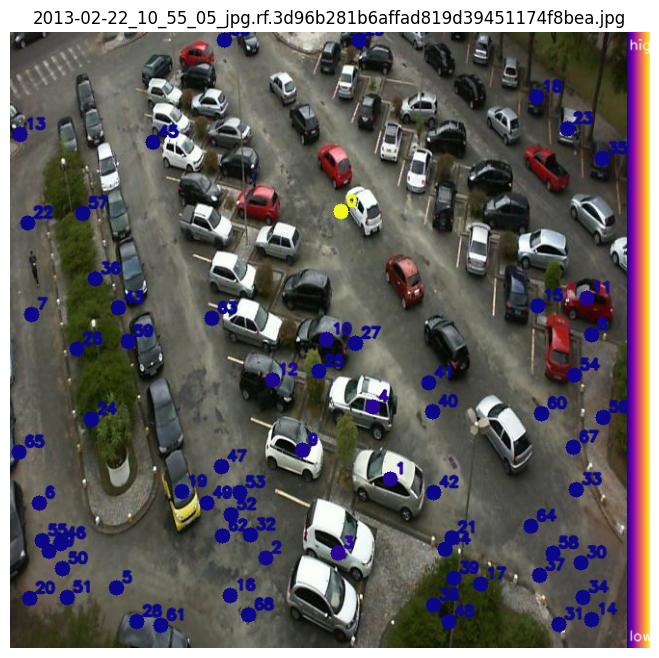

saved: artifacts/figures/centroids_overlay.png


In [32]:
# --- FIXED: centroids overlay with proper colormap + legend bar ---
import pandas as pd, numpy as np, cv2, os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl

pred_map = pd.read_csv("artifacts/analytics/vehicle_predictions_with_spot_id.csv")
pref     = pd.read_csv("artifacts/analytics/spot_preference_vehicle_only.csv")

# choose an image with many detections
img_name = pred_map["image"].value_counts().idxmax()

# locate image path
try:
    sample_img_path = next(p for p in image_paths if Path(p).name == img_name)
except Exception:
    found = list(Path(".").rglob(img_name))
    assert found, f"Could not locate {img_name} on disk."
    sample_img_path = str(found[0])

# load as writable BGR
im_bgr = cv2.imread(sample_img_path)
if im_bgr is None:
    im_bgr = cv2.cvtColor(np.array(Image.open(sample_img_path).convert("RGB")), cv2.COLOR_RGB2BGR)
im_bgr = np.ascontiguousarray(im_bgr)
H, W = im_bgr.shape[:2]

# centroids (mean normalized center per spot)
centroids = (pred_map.dropna(subset=["spot_id"])
             .groupby("spot_id")[["nx","ny"]]
             .mean()
             .reset_index()
             .merge(pref[["spot_id","occupancy_rate"]], on="spot_id", how="left")
             .fillna(0.0))

# colormap (Matplotlib ≥3.7 correct API)
cmap = mpl.colormaps.get_cmap("plasma")
norm = plt.Normalize(0, 1)

# draw centroids colored by occupancy_rate
for _, row in centroids.iterrows():
    cx = int(row["nx"] * W)
    cy = int(row["ny"] * H)
    occ = float(row["occupancy_rate"])
    bgr = tuple(int(255*v) for v in cmap(norm(occ))[:3])[::-1]  # RGBA→BGR
    cv2.circle(im_bgr, (cx, cy), 8, bgr, -1)
    cv2.putText(im_bgr, f"{int(row['spot_id'])}", (cx+6, cy-6),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, bgr, 2, cv2.LINE_AA)

# build a vertical legend bar (height = image, width = 24 px)
legend = np.linspace(0, 1, 256, dtype=np.float32)
legend = np.tile(legend, (20, 1))                      # 20 x 256 strip
legend_rgb = (cmap(legend)[..., :3] * 255).astype(np.uint8)
legend_bgr = legend_rgb[..., ::-1]
legend_bar = cv2.resize(legend_bgr, (24, H), interpolation=cv2.INTER_LINEAR)

# add text labels to legend
cv2.putText(legend_bar, "high", (2, 18), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
cv2.putText(legend_bar, "low",  (2, H-8), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

# concat and show
im_vis = np.hstack([im_bgr, legend_bar])
os.makedirs("artifacts/figures", exist_ok=True)
out_path = "artifacts/figures/centroids_overlay.png"
cv2.imwrite(out_path, im_vis)

plt.figure(figsize=(10,8))
plt.imshow(cv2.cvtColor(im_vis, cv2.COLOR_BGR2RGB))
plt.axis("off"); plt.title(Path(sample_img_path).name)
plt.show()

print("saved:", out_path)


In [33]:
import pandas as pd, numpy as np, cv2, os
from pathlib import Path

df = pd.read_csv("artifacts/analytics/vehicle_predictions_with_spot_id.csv")
out_dir = Path("artifacts/figures/annotated"); out_dir.mkdir(parents=True, exist_ok=True)

images = df["image"].dropna().unique().tolist()[:50]  # first 50
for img_name in images:
    # locate the file on disk
    try:
        img_path = next(p for p in image_paths if Path(p).name == img_name)
    except Exception:
        # fallback search
        found = list(Path(".").rglob(img_name))
        if not found:
            continue
        img_path = str(found[0])

    im_bgr = cv2.imread(img_path)
    if im_bgr is None:
        continue
    im_bgr = np.ascontiguousarray(im_bgr)

    sub = df[df["image"] == img_name].copy()
    for _, r in sub.iterrows():
        x1,y1,x2,y2 = int(r.x1), int(r.y1), int(r.x2), int(r.y2)
        sid = int(r.spot_id) if "spot_id" in r and r.spot_id==r.spot_id else -1
        color = (0,255,0) if sid != -1 else (255,0,0)
        cv2.rectangle(im_bgr, (x1,y1), (x2,y2), color, 2)
        label = f"#{sid}"
        cv2.putText(im_bgr, label, (x1, max(0,y1-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)

    out = out_dir/f"{Path(img_name).stem}_annot.png"
    cv2.imwrite(str(out), im_bgr)

print("saved annotated frames to:", out_dir)


saved annotated frames to: artifacts/figures/annotated


In [34]:
import pandas as pd
pref = pd.read_csv("artifacts/analytics/spot_preference_vehicle_only.csv")
K = 15
top = pref.nlargest(K, ["occupancy_rate","total_hits"])
display(top.style.format({"occupancy_rate":"{:.3f}", "mean_confidence":"{:.3f}"}))


In [35]:
from pathlib import Path
import pandas as pd, numpy as np

PRED_FLAT = Path("artifacts/predictions/predictions_flat.csv")
WITH_SPOT = Path("artifacts/analytics/vehicle_predictions_with_spot_id.csv")
SPOT_PREF = Path("artifacts/analytics/spot_preference_vehicle_only.csv")

df_pred = pd.read_csv(PRED_FLAT)
df_map  = pd.read_csv(WITH_SPOT)
pref    = pd.read_csv(SPOT_PREF)

# ensure normalized coords exist for maps
if not {"nx","ny"}.issubset(df_map.columns):
    df_map["nx"] = df_map["cx"]/df_map["width"]
    df_map["ny"] = df_map["cy"]/df_map["height"]

# if image_paths vanished, rebuild from disk
try:
    image_paths
except NameError:
    def _scan(root="."):
        exts={".jpg",".jpeg",".png",".bmp"}; root=Path(root)
        return [str(p) for p in root.rglob("*") if p.suffix.lower() in exts]
    image_paths = _scan(".")


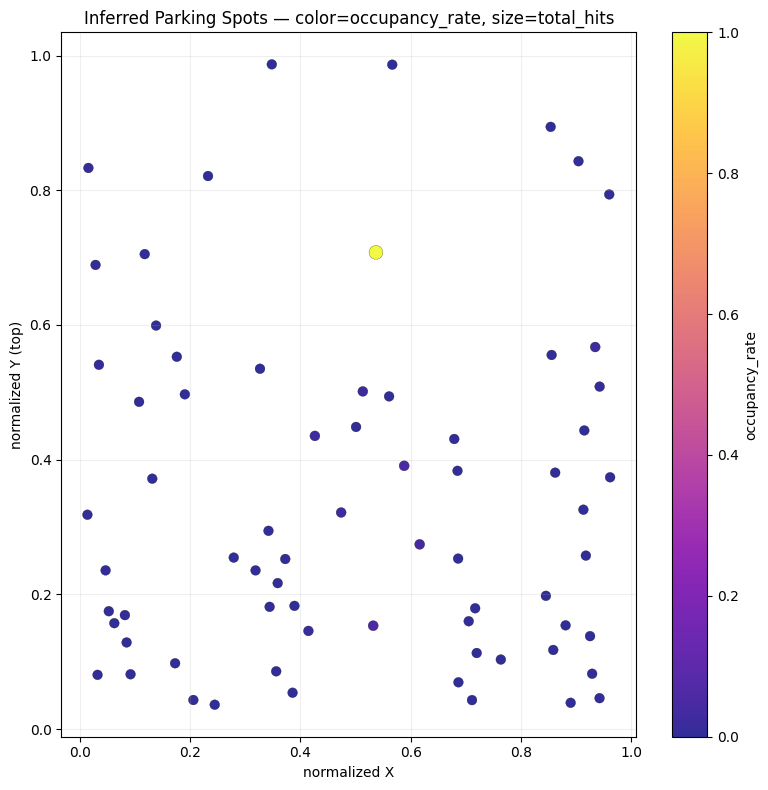

In [37]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

# Build centroids table (one row per inferred spot)
centroids = (
    df_map.dropna(subset=["spot_id"])
          .groupby("spot_id")[["nx","ny"]].mean().reset_index()
          .merge(pref, on="spot_id", how="left")
          .fillna({"occupancy_rate": 0, "total_hits": 0})
)

if centroids.empty:
    raise ValueError("No centroids available – check that clustering produced spot_id values.")

# Visual params
cmap = mpl.colormaps.get_cmap("plasma")
norm = plt.Normalize(0, 1)

sizes = 50 * (1 + centroids["total_hits"] / max(1, centroids["total_hits"].max()))
colors = centroids["occupancy_rate"].clip(0, 1)

# Figure + Axes explicit → keep a handle to the scatter mappable
fig, ax = plt.subplots(figsize=(8, 8))
sc = ax.scatter(
    centroids["nx"], 1 - centroids["ny"],         # flip Y for top-down feel
    s=sizes, c=colors, cmap=cmap, norm=norm,
    alpha=0.85, edgecolors="k", linewidths=0.2
)

ax.set_title("Inferred Parking Spots — color=occupancy_rate, size=total_hits")
ax.set_xlabel("normalized X")
ax.set_ylabel("normalized Y (top)")
ax.grid(alpha=0.2)

# Proper colorbar attached to this figure/axes
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("occupancy_rate")

fig.tight_layout()
plt.show()


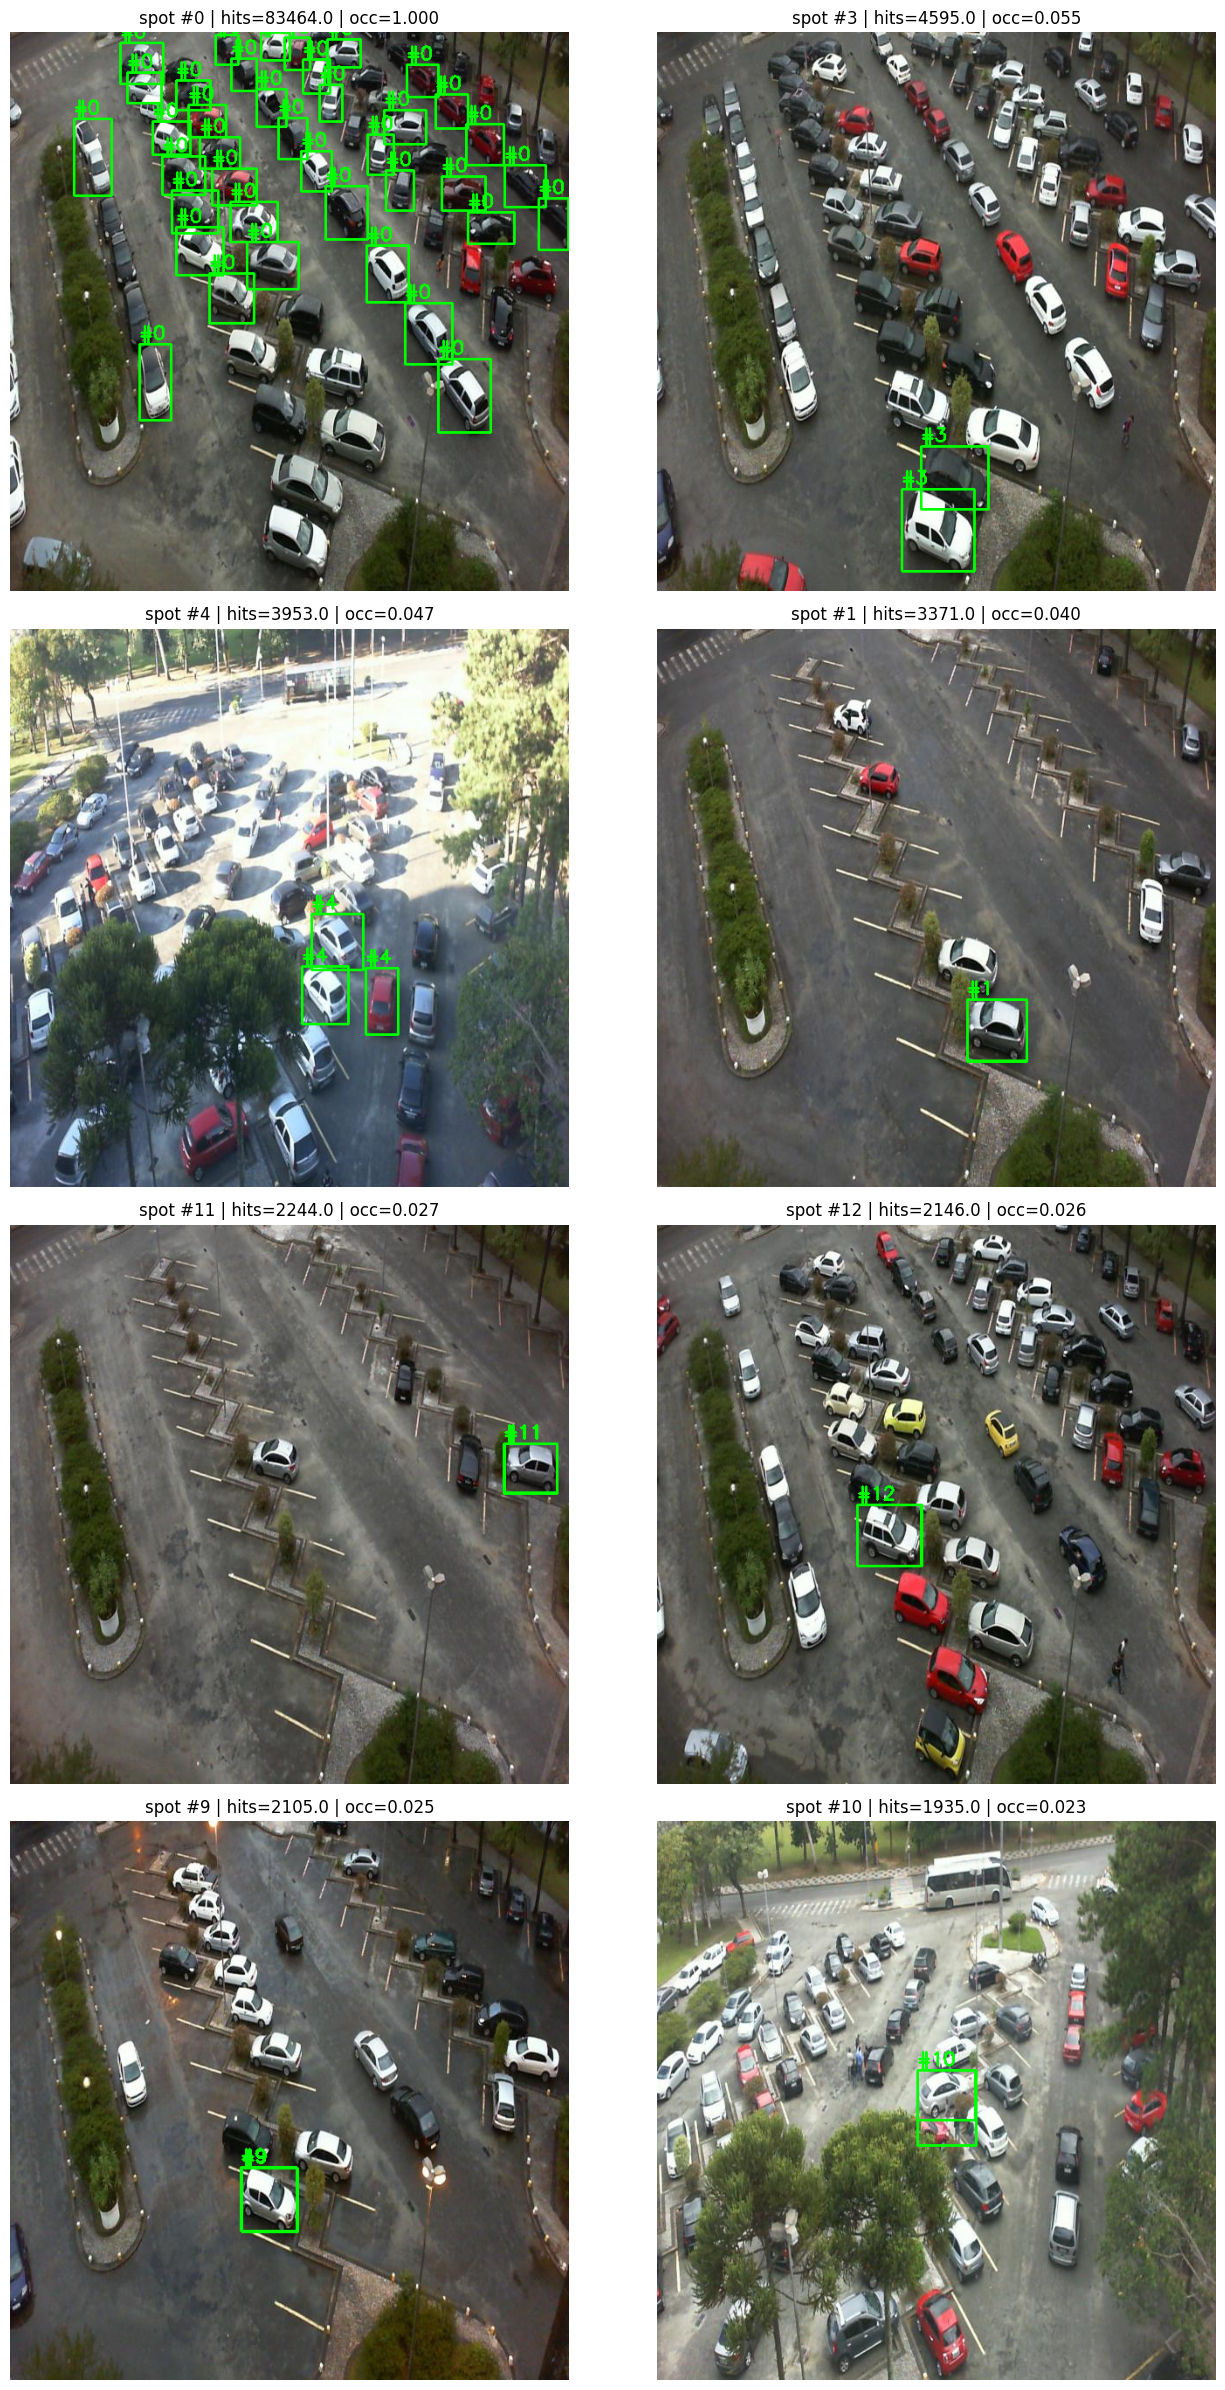

In [38]:
import cv2, numpy as np, random, os
from pathlib import Path
import matplotlib.pyplot as plt

K = 8  # show top 8
top = pref.nlargest(K, ["occupancy_rate","total_hits"]).copy()

# pick one representative frame per top spot (the image where it appears most)
rep = []
for sid in top["spot_id"]:
    sub = df_map[df_map["spot_id"]==sid]
    img = sub["image"].value_counts().idxmax()
    rep.append((sid, img))

# locate paths
def find_path(name):
    for p in image_paths:
        if Path(p).name == name: return p
    # fallback search
    found = list(Path(".").rglob(name))
    return str(found[0]) if found else None

fig, axes = plt.subplots(nrows=(K+1)//2, ncols=2, figsize=(14, 6*((K+1)//2)))
axes = axes.flatten()

for ax,(sid,img_name) in zip(axes, rep):
    p = find_path(img_name)
    if not p: continue
    im = cv2.imread(p); im = np.ascontiguousarray(im)
    sub = df_map[(df_map["image"]==img_name) & (df_map["spot_id"]==sid)]
    for _, r in sub.iterrows():
        x1,y1,x2,y2 = map(int, [r.x1,r.y1,r.x2,r.y2])
        cv2.rectangle(im,(x1,y1),(x2,y2),(0,255,0),2)
        cv2.putText(im, f"#{sid}", (x1, max(0,y1-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0,255,0),2)
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    meta = pref.loc[pref["spot_id"]==sid].iloc[0]
    ax.set_title(f"spot #{sid} | hits={meta.total_hits} | occ={meta.occupancy_rate:.3f}")
    ax.axis("off")

plt.tight_layout()
os.makedirs("artifacts/figures", exist_ok=True)
plt.savefig("artifacts/figures/topK_spots_gallery.png", dpi=160)
plt.show()


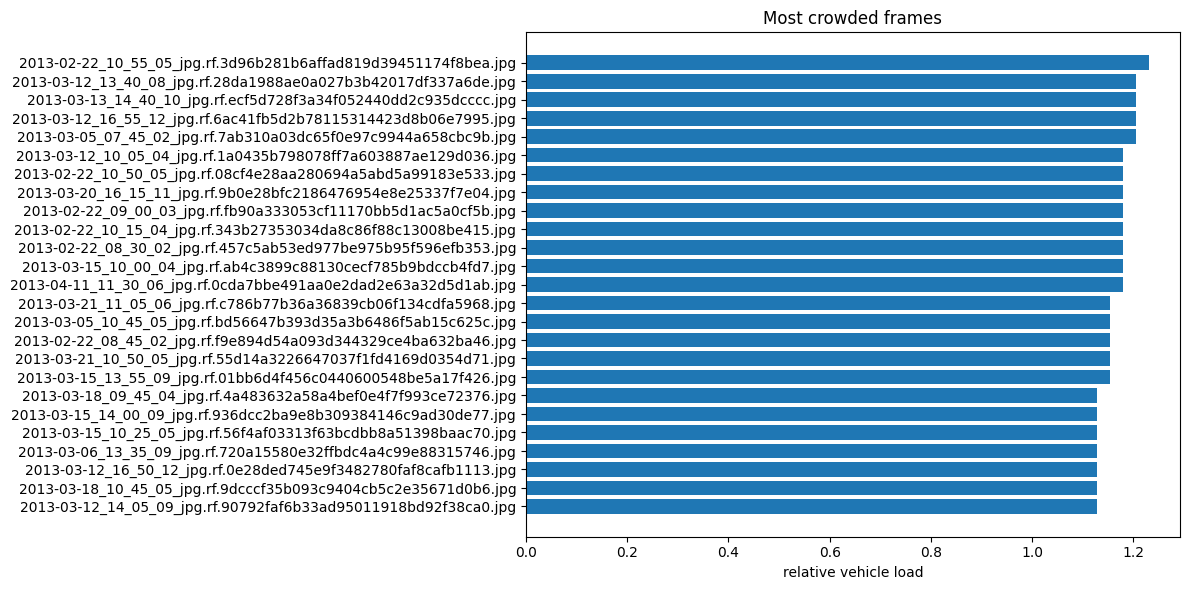

In [39]:
# derive per-image occupied ratio
per_image = (df_map.assign(is_occ=(df_map["cls_name"].str.lower().isin(["car","truck","bus","motorcycle"]) |
                                   (df_map.get("cls_name","")== "occupied")).astype(int))
             .groupby("image")
             .agg(vehicles=("is_occ","sum"))
             .reset_index())
# normalize by 95th percentile to make bars comparable
per_image["score"] = per_image["vehicles"]/max(1, np.percentile(per_image["vehicles"], 95))
top_frames = per_image.sort_values("score", ascending=False).head(25)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.barh(top_frames["image"], top_frames["score"])
plt.gca().invert_yaxis()
plt.xlabel("relative vehicle load"); plt.title("Most crowded frames")
plt.tight_layout(); plt.show()


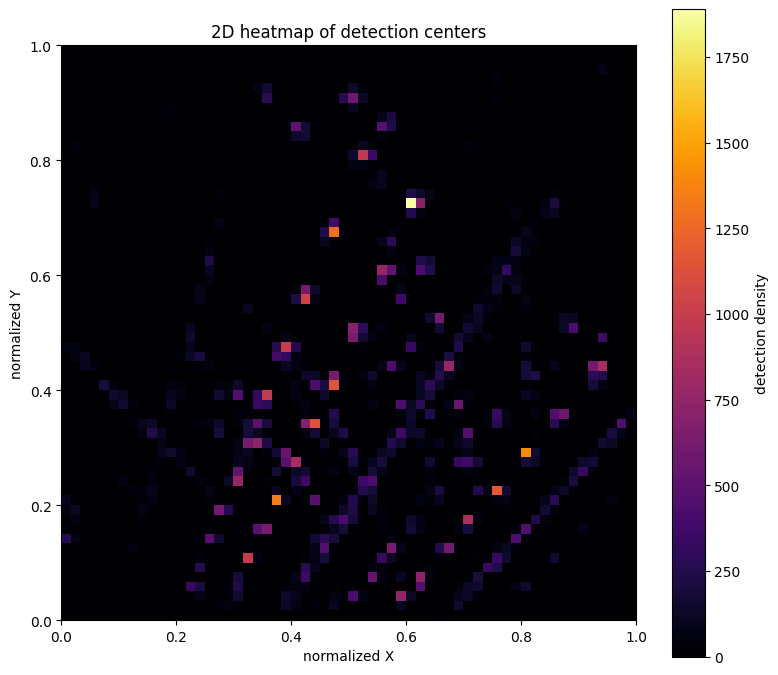

In [40]:
import matplotlib.pyplot as plt
nx = df_map["nx"].to_numpy()
ny = df_map["ny"].to_numpy()
H2, xedges, yedges = np.histogram2d(nx, ny, bins=60, range=[[0,1],[0,1]])

plt.figure(figsize=(8,7))
plt.imshow(H2.T, origin="lower", extent=[0,1,0,1], cmap="inferno")
plt.colorbar(label="detection density")
plt.title("2D heatmap of detection centers")
plt.xlabel("normalized X"); plt.ylabel("normalized Y")
plt.tight_layout(); plt.show()


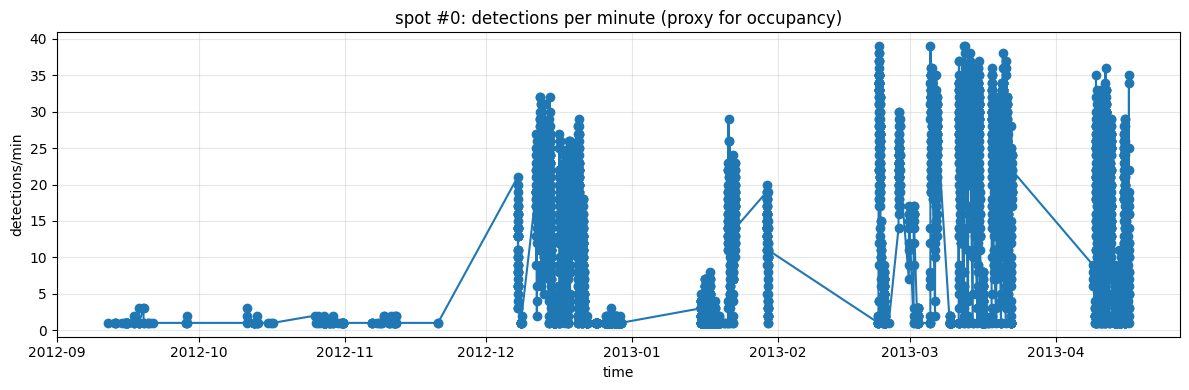

In [41]:
import re, matplotlib.pyplot as plt
sid = int(pref.sort_values(["occupancy_rate","total_hits"], ascending=False).iloc[0]["spot_id"])  # choose hottest
sub = df_map[df_map["spot_id"]==sid].copy()

# try to parse datetime from filename
def parse_dt(name):
    # examples: 2013-03-12_09_30_04.jpg or 2012-09-11_15_29_29.jpg
    m = re.search(r"(\d{4}-\d{2}-\d{2})[_\-](\d{2})[_\-](\d{2})[_\-](\d{2})", name)
    if not m: return None
    from datetime import datetime
    return datetime.strptime("".join([m.group(1)," ",m.group(2),":",m.group(3),":",m.group(4)]), "%Y-%m-%d %H:%M:%S")

sub["dt"] = sub["image"].map(parse_dt)
sub = sub.dropna(subset=["dt"]).sort_values("dt")
ts = sub.groupby(sub["dt"].dt.floor("min")).size()

plt.figure(figsize=(12,4))
plt.plot(ts.index, ts.values, marker="o")
plt.title(f"spot #{sid}: detections per minute (proxy for occupancy)")
plt.xlabel("time"); plt.ylabel("detections/min")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


In [42]:
from IPython.display import Markdown, display
display(Markdown("""
**Columns:**
- `spot_id` — cluster ID (≈ physical parking spot).
- `total_hits` — how many vehicle detections fell into this spot across all frames.
- `unique_images` — in how many distinct frames this spot had a vehicle.
- `mean_confidence` — average model confidence for those detections.
- `occupancy_rate` — normalized popularity of the spot (=`total_hits` / max(`total_hits`)).
    - 1.000 = most used spot.
"""))



**Columns:**
- `spot_id` — cluster ID (≈ physical parking spot).
- `total_hits` — how many vehicle detections fell into this spot across all frames.
- `unique_images` — in how many distinct frames this spot had a vehicle.
- `mean_confidence` — average model confidence for those detections.
- `occupancy_rate` — normalized popularity of the spot (=`total_hits` / max(`total_hits`)).
    - 1.000 = most used spot.


In [44]:
import pandas as pd, numpy as np
from pathlib import Path
from scipy.spatial import cKDTree

m = (pd.read_csv("artifacts/analytics/vehicle_predictions_with_spot_id.csv")
       .dropna(subset=["spot_id","nx","ny"])
       .copy())
m["spot_id"] = m["spot_id"].astype(int)

# --- centroids (normalized) for each inferred spot ---
centroids = (m.groupby("spot_id")[["nx","ny"]]
               .mean()
               .rename(columns={"nx":"snx","ny":"sny"})
               .reset_index())

# --- all frames × all spots grid (so 'free' can be represented explicitly) ---
frames = m[["image"]].drop_duplicates()
spots  = centroids[["spot_id"]]
grid   = frames.merge(spots, how="cross")

# --- link detections to their spot centroid (for stats) ---
mx = m.merge(centroids, on="spot_id", how="left")

# --- straddle-like flag: a detection whose center is within eps of >=2 spot centroids ---
tree = cKDTree(centroids[["snx","sny"]].to_numpy())
eps = 0.03  # tune 0.02–0.05 if needed

mx["straddle_like"] = False  # pre-allocate

for img, d in mx.groupby("image", sort=False):
    q = d[["nx","ny"]].to_numpy()
    # list of lists: indices of centroids within radius eps
    hits = tree.query_ball_point(q, r=eps)
    near_two = np.fromiter((len(h) >= 2 for h in hits), dtype=bool, count=len(hits))
    mx.loc[d.index, "straddle_like"] = near_two

# --- per (image, spot) aggregation ---
stat = (mx.groupby(["image","spot_id"], as_index=False)
          .agg(veh=("image","size"),
               straddle=("straddle_like","any")))

# --- join back to full grid; fill missing as free ---
out = (grid.merge(stat, on=["image","spot_id"], how="left")
           .fillna({"veh":0,"straddle":False}))

def label_row(r):
    if r["veh"] == 0:
        return "free"
    return "partially_free" if r["straddle"] else "occupied"

out["status"] = out.apply(label_row, axis=1)

out_path = "artifacts/analytics/spot_frame_status.csv"
out.to_csv(out_path, index=False)
print("saved:", out_path, "| rows:", len(out))


/tmp/ipython-input-2833128592.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna({"veh":0,"straddle":False}))


saved: artifacts/analytics/spot_frame_status.csv | rows: 411040


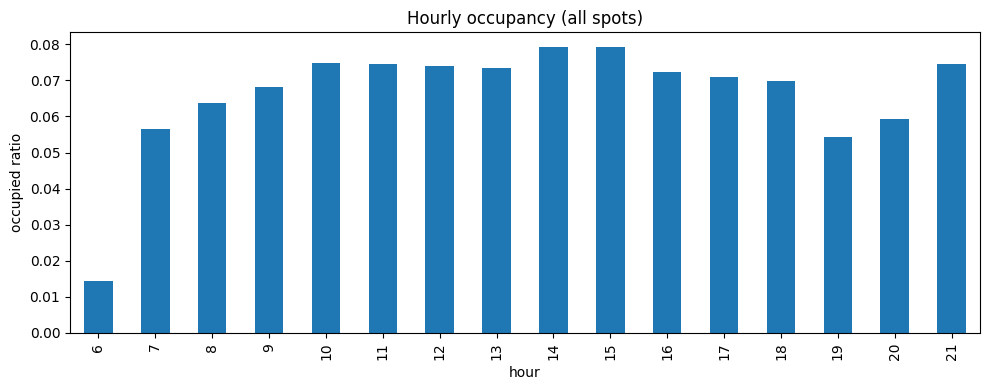

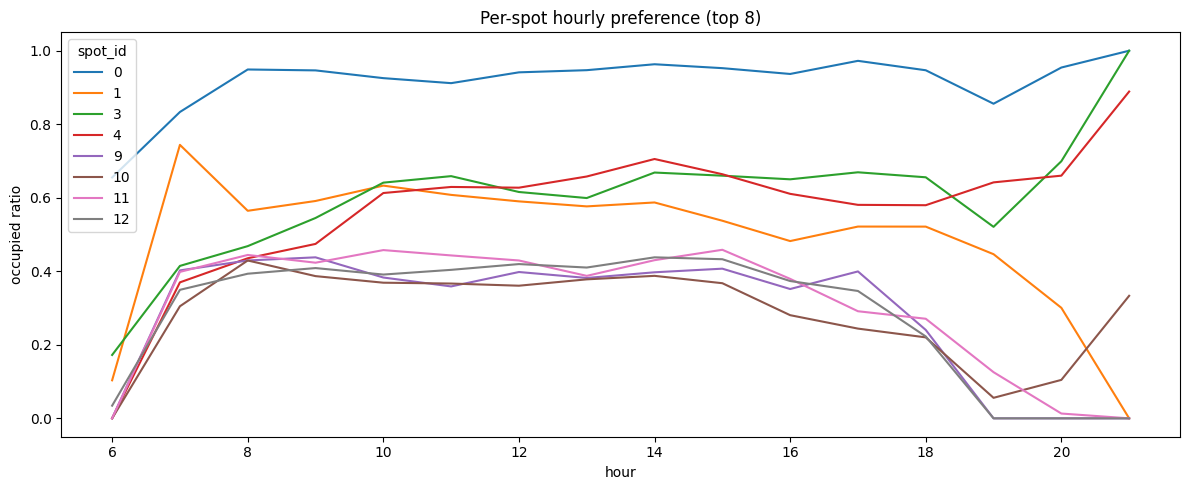

In [45]:
import re, pandas as pd, numpy as np, matplotlib.pyplot as plt

sf = pd.read_csv("artifacts/analytics/spot_frame_status.csv")

def parse_dt(name):
    m = re.search(r"(\d{4}-\d{2}-\d{2})[_\-](\d{2})[_\-](\d{2})[_\-](\d{2})", name)
    if not m: return pd.NaT
    return pd.to_datetime(f"{m.group(1)} {m.group(2)}:{m.group(3)}:{m.group(4)}")

sf["dt"] = sf["image"].map(parse_dt)
sf = sf.dropna(subset=["dt"])
sf["hour"] = sf["dt"].dt.hour

# global: occupied ratio by hour
hourly = (sf.assign(is_occ=(sf["status"]=="occupied").astype(int))
            .groupby("hour")["is_occ"].mean())

plt.figure(figsize=(10,4))
hourly.plot(kind="bar"); plt.ylabel("occupied ratio"); plt.title("Hourly occupancy (all spots)")
plt.tight_layout(); plt.show()

# per-spot preference by hour (top 8 spots)
top_spots = (sf[sf["status"]=="occupied"].groupby("spot_id").size().nlargest(8).index)
pivot = (sf[sf["spot_id"].isin(top_spots)]
         .assign(is_occ=(sf["status"]=="occupied").astype(int))
         .pivot_table(index="hour", columns="spot_id", values="is_occ", aggfunc="mean"))
pivot.plot(figsize=(12,5)); plt.ylabel("occupied ratio"); plt.title("Per-spot hourly preference (top 8)")
plt.tight_layout(); plt.show()


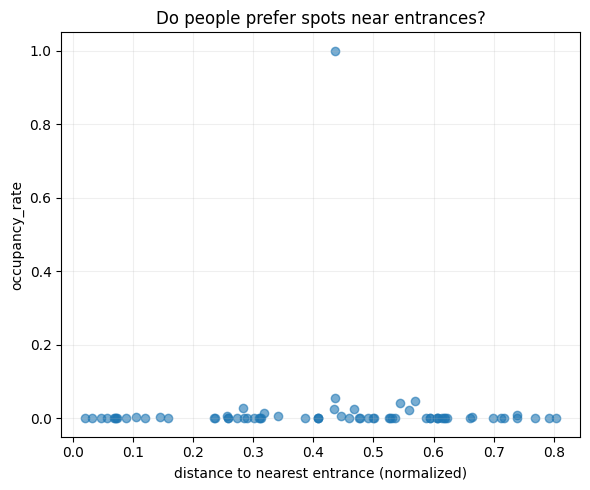

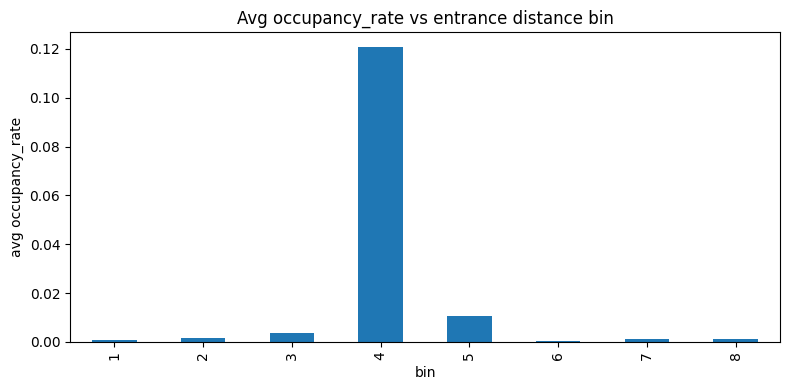

In [46]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# 0..1 normalized entrance points; set quickly by eyeballing your minimap
ENTRANCES = [(0.10, 0.90), (0.95, 0.15)]  # (nx, ny) — edit as per your lot

centroids = pd.read_csv("artifacts/analytics/spot_preference_vehicle_only.csv").merge(
    (pd.read_csv("artifacts/analytics/vehicle_predictions_with_spot_id.csv")
       .dropna(subset=["spot_id"]).groupby("spot_id")[["nx","ny"]].mean().reset_index()),
    on="spot_id", how="left"
)

def dmin(nx, ny, pts):
    return min(np.hypot(nx-ex, ny-ey) for (ex,ey) in pts)

centroids["dist_to_entrance"] = centroids.apply(lambda r: dmin(r["nx"], r["ny"], ENTRANCES), axis=1)

plt.figure(figsize=(6,5))
plt.scatter(centroids["dist_to_entrance"], centroids["occupancy_rate"], alpha=0.6)
plt.xlabel("distance to nearest entrance (normalized)"); plt.ylabel("occupancy_rate")
plt.title("Do people prefer spots near entrances?")
plt.grid(alpha=0.2); plt.tight_layout(); plt.show()

# bin-wise mean
bins = np.linspace(0, centroids["dist_to_entrance"].max(), 8)
centroids["bin"] = np.digitize(centroids["dist_to_entrance"], bins)
bin_mean = centroids.groupby("bin")["occupancy_rate"].mean()
bin_mean.plot(kind="bar", figsize=(8,4), title="Avg occupancy_rate vs entrance distance bin")
plt.ylabel("avg occupancy_rate"); plt.tight_layout(); plt.show()


In [47]:
import pandas as pd, numpy as np

pf = pd.read_csv("artifacts/predictions/predictions_flat.csv")  # raw vehicle boxes
pf["image"] = pf["image"].astype(str)

def iou(a, b):
    ax1, ay1, ax2, ay2 = a; bx1, by1, bx2, by2 = b
    inter_x1, inter_y1 = max(ax1,bx1), max(ay1,by1)
    inter_x2, inter_y2 = min(ax2,bx2), min(ay2,by2)
    iw, ih = max(0, inter_x2-inter_x1), max(0, inter_y2-inter_y1)
    inter = iw*ih
    ua = (ax2-ax1)*(ay2-ay1) + (bx2-bx1)*(by2-by1) - inter
    return inter / (ua + 1e-9)

incidents = []
for img, g in pf.groupby("image"):
    boxes = g[["x1","y1","x2","y2"]].to_numpy()
    n = len(boxes)
    for i in range(n):
        for j in range(i+1,n):
            if iou(boxes[i], boxes[j]) >= 0.30:
                incidents.append({"image": img, "type": "double_parking", "i": i, "j": j})

improper = pd.DataFrame(incidents)

# add straddling (from earlier status table)
status = pd.read_csv("artifacts/analytics/spot_frame_status.csv")
straddle = (status[status["status"]=="partially_free"][["image","spot_id"]]
            .assign(type="straddle_two_spots"))
improper = pd.concat([improper, straddle], ignore_index=True)
improper_path = "artifacts/analytics/improper_parking_events.csv"
improper.to_csv(improper_path, index=False)
print("saved incidents:", improper_path)


saved incidents: artifacts/analytics/improper_parking_events.csv


In [48]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

sf = pd.read_csv("artifacts/analytics/spot_frame_status.csv")
sf["is_occ"] = (sf["status"]=="occupied").astype(int)

# order by time per spot
import re
def parse_dt(name):
    m = re.search(r"(\d{4}-\d{2}-\d{2})[_\-](\d{2})[_\-](\d{2})[_\-](\d{2})", name)
    if not m: return pd.NaT
    return pd.to_datetime(f"{m.group(1)} {m.group(2)}:{m.group(3)}:{m.group(4)}")
sf["dt"] = sf["image"].map(parse_dt)
sf = sf.dropna(subset=["dt"]).sort_values(["spot_id","dt"]).reset_index(drop=True)
sf["hour"] = sf["dt"].dt.hour

# 1-step lag per spot
sf["lag_occ"] = sf.groupby("spot_id")["is_occ"].shift(1).fillna(0).astype(int)

# train/test split by time (last 20% time as test)
cut = sf["dt"].quantile(0.8)
train, test = sf[sf["dt"]<=cut], sf[sf["dt"]>cut]

X_tr = np.c_[train["hour"], train["lag_occ"]]
X_te = np.c_[test["hour"],  test["lag_occ"]]
y_tr, y_te = train["is_occ"].values, test["is_occ"].values

clf = LogisticRegression(max_iter=1000)
clf.fit(X_tr, y_tr)
proba = clf.predict_proba(X_te)[:,1]
auc = roc_auc_score(y_te, proba)
print(f"Baseline next-frame occupancy AUC: {auc:.3f}")


Baseline next-frame occupancy AUC: 0.934
